# Analyzing and managing single-spot analysis referenced to spectral imaging for artworks diagnostics

## Disclamer
For teaching purpose, here we explain every function and how to use the method on real data set of a painting by Vittore Carpaccio  collected during Hyperion project by Nicole De Manincor, Enrico Fiorin and Marco Raffaelli  (in alphabetical order). Because, the data is not owned by the author of the notebook we show the procedure only on a limited data set of only four points. To take full advantage of the method only four observations are not sufficient, to see an application to large dataset see "Integration of multispectral visible-infrared imaging and pointwise X-ray fluorescence data for the analysis of a large canvas painting by Carpaccio" Microchemical Journal, (to be published 2019). The test data in this notebook can not be reused without consent.
The test data in this notebook can not be reused without consent.

## Installation of the dependencies
We install the dependencies. There no need to run this cell if you done it once. If you don't have the permission run this commands in the terminal as root (e.g. sudo pip instal ...).

In [ ]:
!pip install rasterio
!pip install pyshp

In [1]:
#Python 2.7 compatibility
from __future__ import print_function
import rasterio # for loading the rasters
from rasterio import plot as rasterplot
import shapefile # for loading the XRF shapefile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # for visualizing the tabels
import os 
%matplotlib inline

In [110]:
plt.rcParams.update({'font.size': 22}) # set the font size 
plt.rcParams['figure.figsize'] = (12,7) # set the figure size

## Aim of the method and 
The aim of the study is to apply and evaluate a methodology for joining the data coming from a single spot analyses referenced to a multi-spectral stack on large paintings.

In [111]:
examplesdir = os.getcwd()
if 'examples' not in os.getcwd():
    print("Please, assign to examplesdir the directory of the examples folder.")
      

## Description of the dataset
The dataset contains a __[shape file](https://it.wikipedia.org/wiki/Shapefile)__ with the coordinates of the XRF measurement and the multispectral cube exported in .lan format. 
The data-fusion process uses the coordinates of the XRF measurements to extract the reflectance values from each band of the multi-spectral cube in the same position where the XRF has been collected. The raster file is composed of 32 bands below we create an array with the center wavelength of each band. Using rasterio and shapefile Python library we can open import the data.

In [135]:
pathraster = os.path.join(examplesdir,'testdata','testdata.tif')
# we import the raster
raster = rasterio.open(pathraster)
print(raster.name)
print(raster.width)

/Users/giacomo/Documents/spolverro/examples/testdata/testdata.tif
552


In [140]:
pathshp = os.path.join(examplesdir,'testdata','xrfdata.shp')
# we import the shapefile
sf = shapefile.Reader(pathshp)
xrfpoint = sf.record(3)
print(sf)
fields = [i[0] for i in sf.fields[1:]]
# We have a look to the fields
print("These are the fields labels:")
print(fields)
# and the realtive values of the first record
for i in sf.record(0):
    print(i)

shapefile Reader
    4 shapes (type 'POINT')
    4 records (12 fields)
These are the fields labels:
['DeletionFlag', 'FID', 'K', 'Ca', 'Mn', 'Fe', 'Cu', 'Zn', 'Hg', 'Pb', 'Note', 'Attr']
23
0
42
0
29
0
0
241
163
Red ochre, vermilion
Vermilion as principal pigment


In this case, we don't have the fields labels for the raster band so we create them manually, specifying the central wavelength of the band:

In [130]:
Scanner_bands = np.array(["395 nm", 
 "415 nm", 
 "455 nm", 
 "485 nm", 
 "510 nm", 
 "530 nm", 
 "550 nm", 
 "570 nm", 
 "590 nm", 
 "610 nm", 
 "630 nm", 
 "650 nm", 
 "675 nm", 
 "705 nm", 
 "735 nm", 
 "765 nm", 
 "750 nm", 
 "850 nm", 
 "950 nm", 
 "1050 nm", 
 "1230 nm", 
 "1292 nm", 
 "1400 nm", 
 "1500 nm", 
 "1600 nm", 
 "1705 nm", 
 "1830 nm", 
 "1940 nm", 
 "2100 nm", 
 "2200 nm", 
 "2345 nm", 
 "2550 nm", ])
print(len(Scanner_bands))


32


The first procedure that we define takes as input the shapefile and the raster. It extracts the corresponding raster values for each point of the shapefile within a boundary defined by the ROI_side parameter. The ROI side corresponds to the number of pixel of the side of a square surrounding the spectroscopy point.

In [114]:
def extract_plot(shapefile_path,raster_path,r=1,g=2,b=3,ROI_side=5):
    sf = shapefile.Reader(shapefile_path)
    lan = rasterio.open(raster_path)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    reflectance_perpoint_l = []
    reflectance_stdv = []
    ids = []
    extracted_xrf = []
    resx, resy = lan.res
    def area_ex(coor):
        '''
        This function create a a list of coordinates [x,y]
        within a number of pixel extent around the initial
        value.
        '''
        ls_coor = []
        half_lim = int(ROI_side/2)
        for i in range(-half_lim,half_lim):
            for j in range(-half_lim,half_lim):
                # we multiply the number for the x, y pixel size 
                ls_coor.append([(coor[0] + i)*resx,(coor[1] + j)*resy])
        return ls_coor
      
    for xrfpoint,record in zip(sf.shapes(),sf.records()):
        x,y = xrfpoint.points[0]
        sampling = area_ex([x, y])
        for i in sampling:
            x,y = i
            ax.scatter(x,y,color='w',alpha=0.5)
        # Now we sample the multi-spectral cube
        if x > lan.bounds.left and x < lan.bounds.right and y < lan.bounds.top and y > lan.bounds.bottom:
            generators = lan.sample(area_ex([x, y]))
            extracted_points = [i for i in generators]
            reflectance_perpoint_l.append(np.mean(np.array(extracted_points),axis = 0))
            reflectance_stdv.append(np.std(extracted_points,axis = 1))
            ids.append(record[0])
            extracted_xrf.append(record)
        else:
                print('Sampling out of bound')
    rasterplot.show((lan,(r,g,b)),zorder=0,ax=ax)
    return np.array(reflectance_perpoint_l),extracted_points,ids,np.array(extracted_xrf)

We now apply the  procedure on our test data.

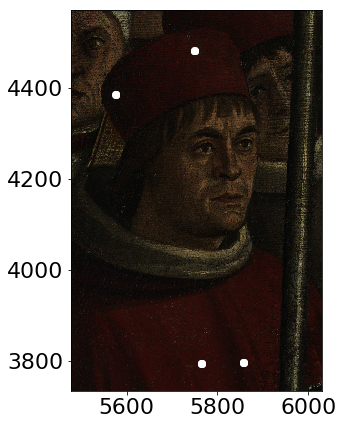

In [138]:
reflectance_perpoint_l,extracted_points,ids, xrfextracted = extract_plot(pathshp,pathraster,r=9,g=6,b=3)

A pandas dataframe is very useful for having an insight on the values extracted in an organized table:

In [123]:
refl_spectra = pd.DataFrame(data=reflectance_perpoint,    # values    # 1st column as index
                             index=ids,
                             columns=Scanner_bands)  # 1st row as the column names
refl_spectra

,395 nm,415 nm,455 nm,485 nm,510 nm,530 nm,550 nm,570 nm,590 nm,610 nm,...,1400 nm,1500 nm,1600 nm,1705 nm,1830 nm,1940 nm,2100 nm,2200 nm,2345 nm,2550 nm
23,23.0000,9.875,11.5000,12.5000,15.8125,15.4375,16.7500,21.1875,36.9375,47.6250,...,95.1875,90.8125,96.5625,82.3125,80.6875,67.6875,103.3125,82.625,53.9375,79.375
24,29.1875,7.375,7.9375,8.3750,10.4375,9.9375,9.3750,10.3125,17.6250,25.6875,...,100.5625,95.6875,97.9375,81.0000,87.5000,64.4375,100.3750,79.875,74.6875,83.500
25,13.1250,9.375,10.4375,11.1875,14.1875,15.1250,21.0625,29.7500,40.9375,45.1875,...,81.0625,62.6875,59.3125,46.0625,45.0625,32.8125,62.1875,47.125,30.2500,57.375
26,25.7500,8.500,8.8125,9.6875,11.9375,11.8125,18.2500,28.0625,37.3750,42.5625,...,67.0000,55.5000,51.1875,31.4375,35.0625,27.8750,59.8750,45.000,14.6875,48.625


We create a dictionary with the location of the single-spot samples. Where we can assign to each ID the location for instance the vestement (mozzetta) or the hat (birretta) in our example. 

In [116]:
locations = {
23:['biretta','y'],
24:['biretta','y'],
25:['mozzetta','m'],
26:['mozzetta','m'],
}

We can create any dictionary storing the label of the measurement, for instance, the pigments attributed. We can use text label (in this case O stand for Red Ochre, V for Vermilion and M for Read lead) or directly the color of the calss that we want to assign (e.g. g(reen) r(ed)).

In [117]:
pigments_attributions = {
    23:['O,V','g'],
    24:['O,V','g'],
    25:['M,O','r'],
    26:['M,O','r'],
}

In this case, we store in the dictionary for each ID the marker and the color that we want to use in the plotting of the data, this can be useful for identifying groups that can be inserted at the same time in two different classes. 

In [118]:
simplelocation = {
    23:['v','g'],
    24:['v','g'],
    25:['v','r'],
    26:['v','r'],
}

## Defining the PCA tool
For computing the PCA we used [`sklearn.decomposition`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from [scikit-learn](https://scikit-learn.org/stable/)  a free software machine learning library for the Python programming language.

> Fabian Pedregosa; Gaël Varoquaux; Alexandre Gramfort; Vincent Michel; Bertrand Thirion; Olivier Grisel; Mathieu Blondel; Peter Prettenhofer; Ron Weiss; Vincent Dubourg; Jake Vanderplas; Alexandre Passos; David Cournapeau; Matthieu Perrot; Édouard Duchesnay (2011). "Scikit-learn: Machine Learning in Python". Journal of Machine Learning Research. 12: 2825–2830.


In [124]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
def plotPCA(dataset,n_components,
            x_component,
            y_component,
            variables_name=None,
            Scaling=False,
            labels = None, 
            colors = None,
            labels_dict = None):
    """
    This function is used to plot the PCA.
    It plots the score plot and the loading plot of two componets. 
    """
    dict_ord = {0:'First',1:'Second',2:'Third',3:'Forth'}
    # compute the trasform
    sklearn_pca = sklearnPCA(n_components=n_components)
    if Scaling: 
        dataset = StandardScaler().fit_transform(dataset)
    sklearn_transf = sklearn_pca.fit_transform(dataset)
    c1exp_variance= round(sklearn_pca.explained_variance_ratio_[x_component]*100,2)
    c2exp_variance= round(sklearn_pca.explained_variance_ratio_[y_component]*100,2)
    
    # SCORE PLOT
    
    figc = plt.figure()
    axc = figc.add_subplot(111)
    axc.set_xlabel('%s component (%s %%)' %(dict_ord[x_component],c1exp_variance))
    axc.set_ylabel('%s component (%s %%)' %(dict_ord[y_component],c2exp_variance))
    xmin = np.min(sklearn_transf[:,x_component])
    xmax = np.max(sklearn_transf[:,x_component])
    ymin = np.min(sklearn_transf[:,y_component])
    ymax = np.max(sklearn_transf[:,y_component])
    axc.set_xlim(xmin+xmin*0.1,xmax+xmax*0.1)
    axc.set_ylim(ymin+ymin*0.1,ymax+ymax*0.1)
    
        
    if colors is None:
        for coord, label in zip(sklearn_transf[:,[x_component,y_component]],
                                labels):
            color = 'k'
            if labels_dict is not None:
                label_txt,color = labels_dict[label]
                label = "%s-%s" %(label,label_txt)
            axc.text(coord[0],coord[1],label,fontsize=13,ha='center',va='center',color = color,clip_on=True)
    else:
        for coord, label,color in zip(sklearn_transf[:,[x_component,y_component]],
                                labels,colors):
            color2 = 'white'
            if labels_dict is not None:
                label_txt,color2 = labels_dict[label]
                label = "%s-%s" %(label,label_txt)
            axc.text(coord[0],coord[1],label,fontsize=13,ha='center',va='center',clip_on=True,color=color2)
            axc.scatter(coord[0],coord[1],marker="o",color=color,s=400)
    
    
    axc.grid(True)
    axc.set_title('Score Plot (Correlation Matrix)')
    # LOADING PLOT
    loadings = sklearn_pca.components_
    figL = plt.figure()
    ax4 = figL.add_subplot(111)
    ax4.plot(loadings[x_component],'x', label="Loadings %s component" %(dict_ord[x_component]),markersize=12)
    ax4.plot(loadings[y_component],'x', label="Loadings %s component" %(dict_ord[y_component]),markersize=12)
    ax4.xaxis.set_ticks(range(0,dataset.shape[1]+1))
    if variables_name is not None:
        ax4.set_xticklabels(variables_name)
    ax4.set_title("Loading plot")
    ax4.set_xlabel(" PC Variables")
    ax4.set_ylabel("Arbitrary")
    ax4.legend()
    ax4.grid()
    plt.setp( ax4.xaxis.get_majorticklabels(), rotation=70 )
    figL.tight_layout()
    

We define also a function for plotting the PCA data in 3D.

In [125]:
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import numpy as np


def plotPCA3D(dataset,n_components,
            x_component,
            y_component,
            z_component,
            variables_name,
            legend_elements=None,
            Scaling=False,
            labels = None, 
            labels_dict = None):
    """
    This function is used to plot the PCA.
    It plots the score plot and the loading plot of two componets. 
    """
    dict_ord = {0:'First',1:'Second',2:'Third',3:'Forth'}
    # compute the trasform
    sklearn_pca = sklearnPCA(n_components=n_components)
    if Scaling: 
        dataset = StandardScaler().fit_transform(dataset)
        
    sklearn_transf = sklearn_pca.fit_transform(dataset)
    c1exp_variance= round(sklearn_pca.explained_variance_ratio_[x_component]*100,2)
    c2exp_variance= round(sklearn_pca.explained_variance_ratio_[y_component]*100,2)
    c3exp_variance= round(sklearn_pca.explained_variance_ratio_[z_component]*100,2)
    #  3D SCORE PLOT
    figc = plt.figure()
    axc = figc.add_subplot(111, projection='3d')
    axc.set_xlabel('%s component \n (%s %%)' %(dict_ord[x_component],c1exp_variance))
    axc.set_ylabel('%s component \n (%s %%)' %(dict_ord[y_component],c2exp_variance))
    axc.set_zlabel('%s component \n (%s %%)' %(dict_ord[z_component],c3exp_variance))
    xmin = np.min(sklearn_transf[:,x_component])
    xmax = np.max(sklearn_transf[:,x_component])
    ymin = np.min(sklearn_transf[:,y_component])
    ymax = np.max(sklearn_transf[:,y_component])
    zmin = np.min(sklearn_transf[:,z_component])
    zmax = np.max(sklearn_transf[:,z_component])
    # for depth shading
    x_range = xmax - xmin
    y_range = ymax - ymin
    axc.set_xlim(xmin+xmin*0.1,xmax+xmax*0.1)
    axc.set_ylim(ymin+ymin*0.1,ymax+ymax*0.1)
    axc.set_zlim(zmin+zmin*0.1,zmax+zmax*0.1)
    axes = figc.gca(projection='3d')
    axes.xaxis.labelpad=30
    axes.yaxis.labelpad=30
    axes.zaxis.labelpad=30
    
        
    for coord, label in zip(sklearn_transf[:,[x_component,y_component,z_component]],
                                labels):
            cxalpha = 0.4*((coord[0]-xmin)/x_range)
            cyalpha = 0.4 - 0.4*((coord[1]-ymin)/y_range)
            alpha = cxalpha+cyalpha+0.2
            marker,color= labels_dict[label]
            axc.scatter(coord[0],coord[1],coord[2],marker=marker,color=color,depthshade=True,s=200*alpha,alpha=alpha)
    
    if legend_elements != None:
      axc.legend(handles=legend_elements)
      axc.legend()
    axc.grid(True)
    axc.set_title('Score Plot (Correlation Matrix)')
    axc.xaxis._axinfo['label']['space_factor'] = 2.8
    axc.dist = 13
    axes = figc.gca(projection='3d')
    axes.xaxis.labelpad=20
    axes.yaxis.labelpad=20
    axes.zaxis.labelpad=20
    # LOADING PLOT
    loadings = sklearn_pca.components_
    figL = plt.figure()
    ax4 = figL.add_subplot(111)
    ax4.plot(loadings[x_component],'x', label="Loadings %s component" %(dict_ord[x_component]),markersize=12)
    ax4.plot(loadings[y_component],'x', label="Loadings %s component" %(dict_ord[y_component]),markersize=12)
    ax4.plot(loadings[z_component],'x', label="Loadings %s component" %(dict_ord[y_component]),markersize=12)
    ax4.xaxis.set_ticks(range(0,dataset.shape[1]+1))
    if variables_name is not None:
        ax4.set_xticklabels(variables_name)
    ax4.set_title("Loading plot",linespacing=3.1)
    ax4.set_xlabel(" PC Variables",linespacing=3.1)
    ax4.set_ylabel("Arbitrary",linespacing=3.1)
    ax4.legend()
    ax4.grid()
    plt.setp( ax4.xaxis.get_majorticklabels(), rotation=70 )
    figL.tight_layout()



Eventually, we define a function for plotting the single spectrum.

In [126]:
def plot_spectrum(dataset,index, variables_name=None,norm=True):
    '''
    Plot the spectrum corresponding to a given sample index.
    '''
    figs = plt.figure()
    ax5 = figs.add_subplot(111)
    if norm:
        spectrum = dataset[index-1,:]/2.55
        ax5.set_ylabel("Reflectance (%)")
        ax5.set_ylim(0,100)
    else:
        spectrum = dataset[index-1,:]
        ax5.set_ylabel("Counts")
    ax5.plot(spectrum,'x',markersize=12)
    ax5.xaxis.set_ticks(range(0,dataset.shape[1]+1))
    if variables_name is not None:
        ax5.set_xticklabels(variables_name)
    ax5.set_title("Spectrum %s" %(index))
    
    
    ax5.legend()
    ax5.grid()
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=70 )
    figs.tight_layout()
    

## Analysis using the PCA on reflectance data
Initially, we perform the PCA only on the mean reflectance data extracted from the multispectral cube. We use the labels extracted and, for highlighting the information of the classes, the pigments_attribution dictionary that we created.

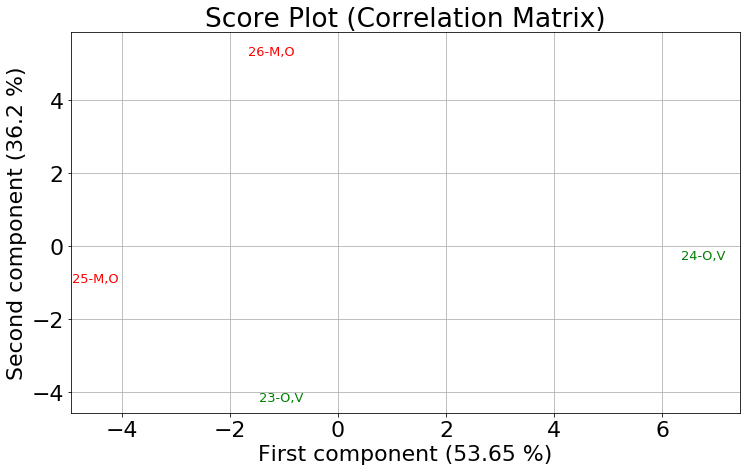

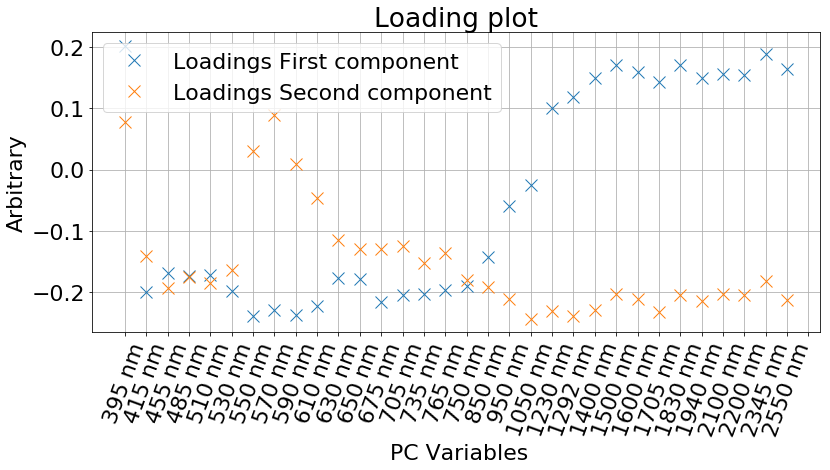

In [137]:
plotPCA(reflectance_perpoint, 
        n_components=3, # number of components to be computed
        x_component=0, # Component displyed on the x axis (second component index 1)
        y_component=1, # Component displyed on the y axis (second component index 1)
        labels=ids,
        variables_name=Scanner_bands,
        labels_dict=pigments_attributions,
        Scaling=True # we use the sandard scaler on the whole dataset.
        )

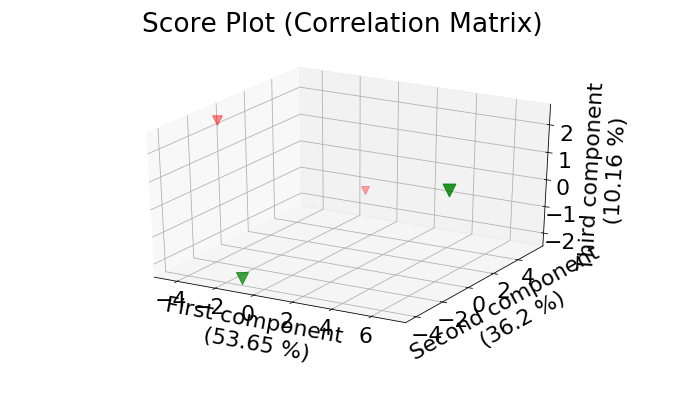

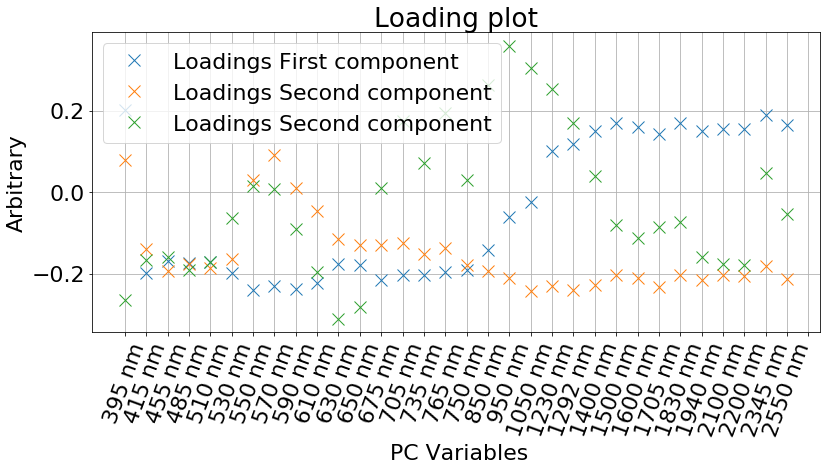

In [128]:
plotPCA3D(reflectance_perpoint,4,0,1,2,labels=ids,variables_name=Scanner_bands,labels_dict=simplelocation,Scaling=True)

No handles with labels found to put in legend.


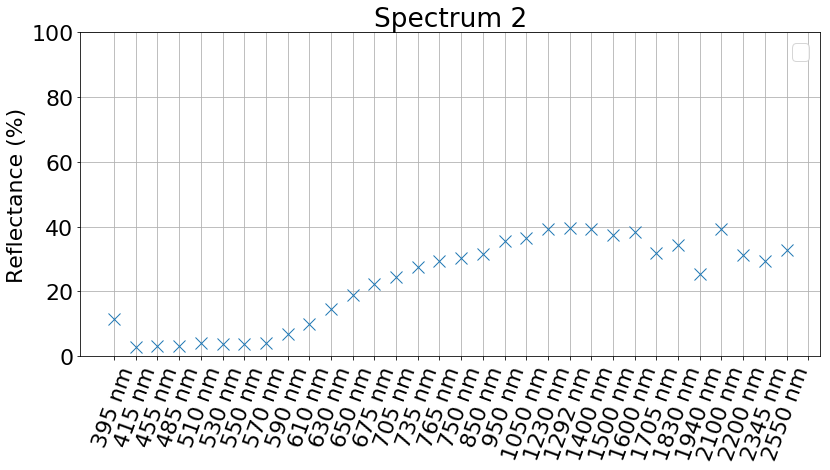

In [129]:
plot_spectrum(reflectance_perpoint,index=2,variables_name=Scanner_bands)

## Analysis using the PCA on XRF data
We analyzed the XRF data separately. We have to take into account that the XRF shapefile could contain other fields not related to spectral information. For instance, in our case, the first field is the ID the last two fields are the attribution.

In [139]:
xrfextracted

array([['23', '0', '42', '0', '29', '0', '0', '241', '163',
        'Red ochre, vermilion', 'Vermilion as principal pigment'],
       ['24', '13', '97', '0', '32', '0', '0', '335', '94',
        'Red ochre, vermilion',
        'Probable addition of red lake as a glaze'],
       ['25', '0', '18', '0', '44', '0', '0', '0', '455',
        'Red lead, red ochre', ''],
       ['26', '0', '23', '0', '139', '0', '0', '0', '336',
        'Red lead, red ochre',
        'Addition of red ochre in the shadow of the folds']], dtype='<U48')

We extract only the spectroscopy fields.

In [100]:
#XRFdataset = np.array([i[1:-2] for i in sf.records()]) # alternative way
XRFdataset = np.array(sf.records())[:,1:-2].astype(int)[:,1:]
print(XRFdataset.shape)
vn =np.array(sf.fields[2:-2])[1:,0]

(4, 7)


We can now perform the PCA only on the XRF data.

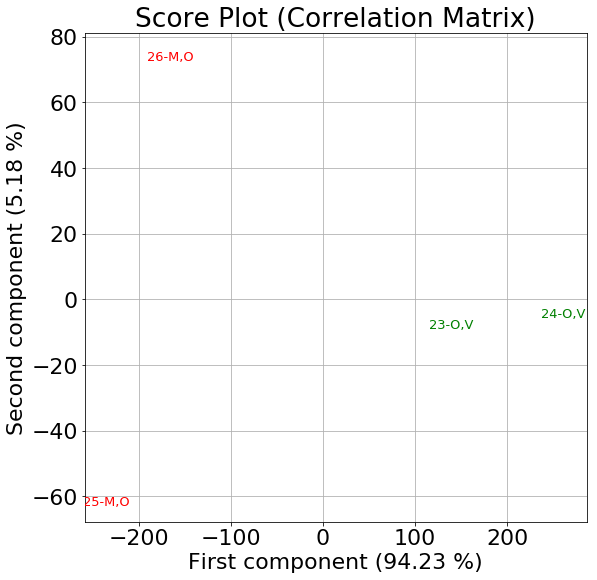

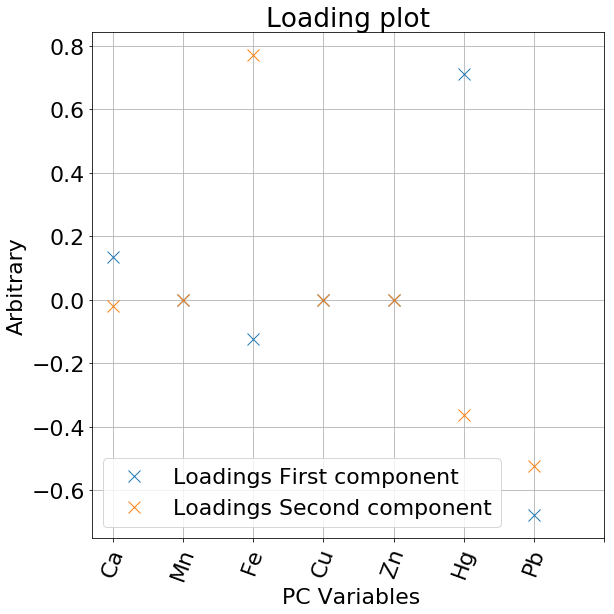

In [101]:
plotPCA(XRFdataset,3,0,1,labels=ids,variables_name=vn,labels_dict=pigments_attributions)

/Users/giacomo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/giacomo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


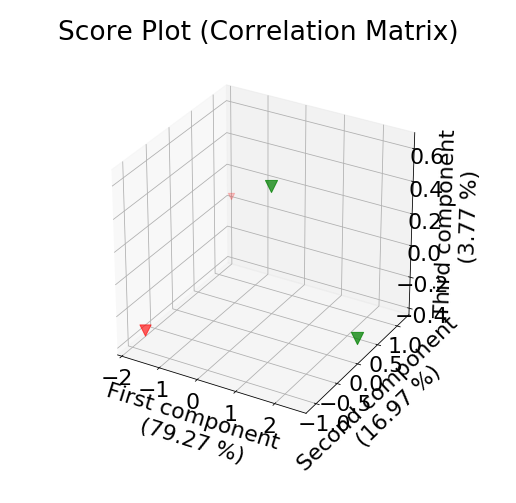

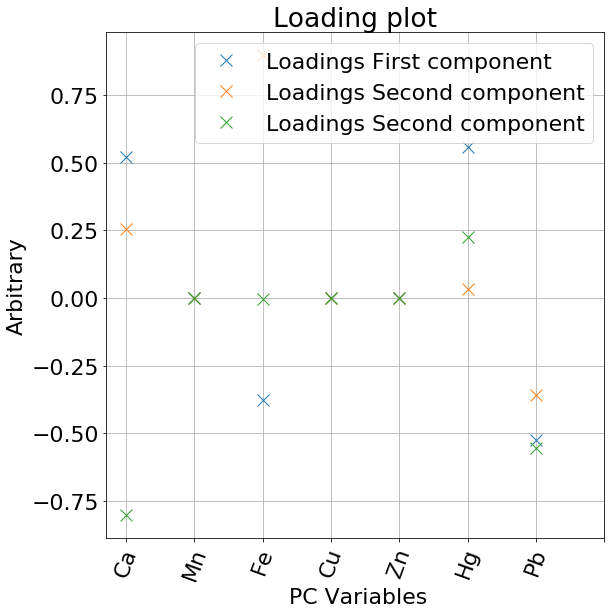

In [102]:
plotPCA3D(XRFdataset,4,0,1,2,labels=ids,variables_name=vn,labels_dict=simplelocation,Scaling=True)

## PCA analysis of reflectance and XRF data joined toghether
Eventually, we joined the reflectance and XRF data in a single vector. Even here we can decide to exclude some noisy bands from the computation.

In [103]:
xrf_ref = np.hstack((XRFdataset,reflectance_perpoint))[:,:-2] # we can decide to exclude the last two bands [:,:-2]
variables_name = list(vn) + list(Scanner_bands)[:-2] # This are the name of every variable
print(xrf_ref.shape)
print(len(variables_name))

(4, 35)
35


In [104]:
xrf_ref_table = pd.DataFrame(data=xrf_ref,    # values    # 1st column as index
                             index=ids,
                             columns=variables_name)  # 1st row as the column names
xrf_ref_table

,Ca,Mn,Fe,Cu,Zn,Hg,Pb,395 nm,415 nm,455 nm,...,950 nm,1050 nm,1230 nm,1292 nm,1400 nm,1500 nm,1600 nm,1705 nm,1830 nm,1940 nm
23,42.0,0.0,29.0,0.0,0.0,241.0,163.0,23.0000,9.875,11.5000,...,91.3750,94.0625,94.3750,95.9375,95.1875,90.8125,96.5625,82.3125,80.6875,67.6875
24,97.0,0.0,32.0,0.0,0.0,335.0,94.0,29.1875,7.375,7.9375,...,90.5625,93.1250,100.1250,100.9375,100.5625,95.6875,97.9375,81.0000,87.5000,64.4375
25,18.0,0.0,44.0,0.0,0.0,0.0,455.0,13.1250,9.375,10.4375,...,97.6250,97.7500,94.8125,92.0000,81.0625,62.6875,59.3125,46.0625,45.0625,32.8125
26,23.0,0.0,139.0,0.0,0.0,0.0,336.0,25.7500,8.500,8.8125,...,82.3125,83.1250,78.1875,76.0000,67.0000,55.5000,51.1875,31.4375,35.0625,27.8750


Finally, we can compute the PCA on the joint dataset.

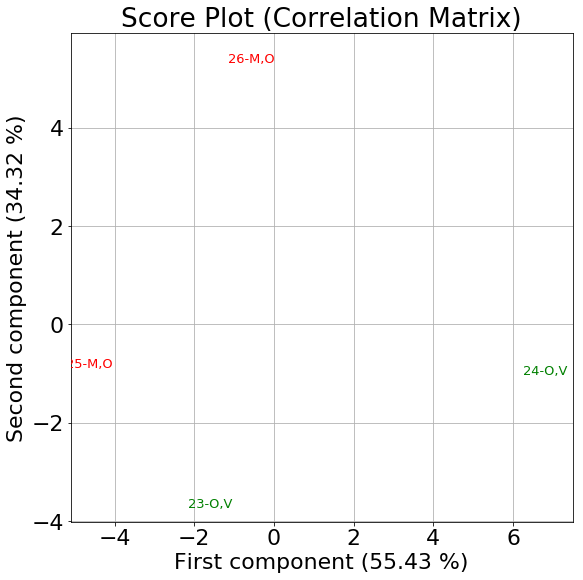

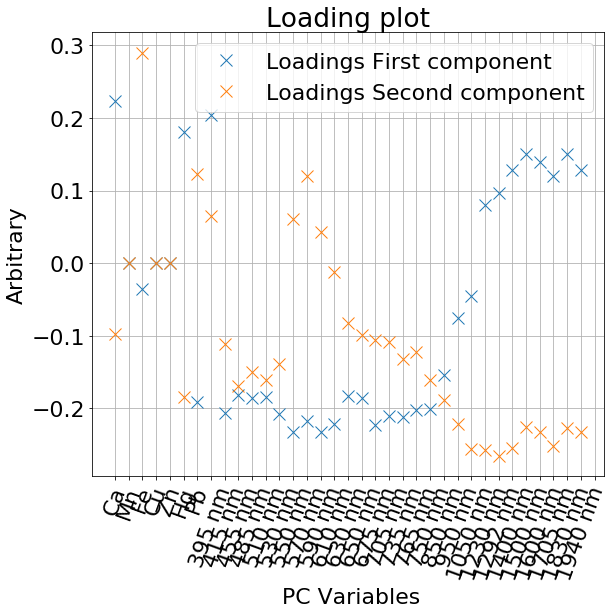

In [105]:
plotPCA(xrf_ref,4,0,1,labels = ids,variables_name = variables_name,labels_dict=pigments_attributions,Scaling=True)

No handles with labels found to put in legend.


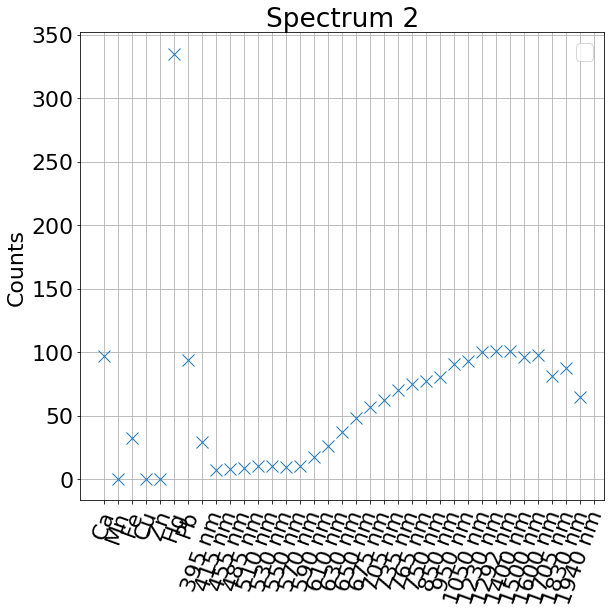

In [106]:
plot_spectrum(xrf_ref,index=2,variables_name=variables_name,norm=False)

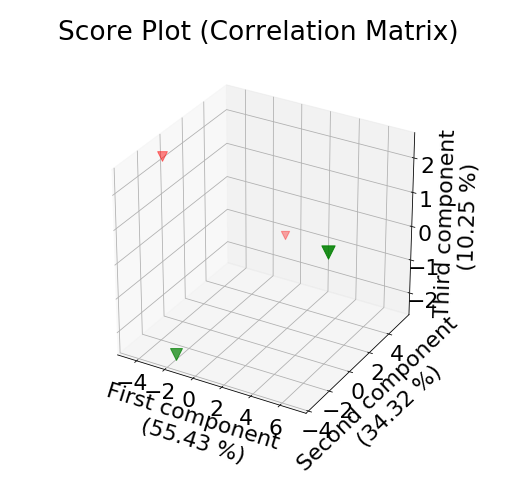

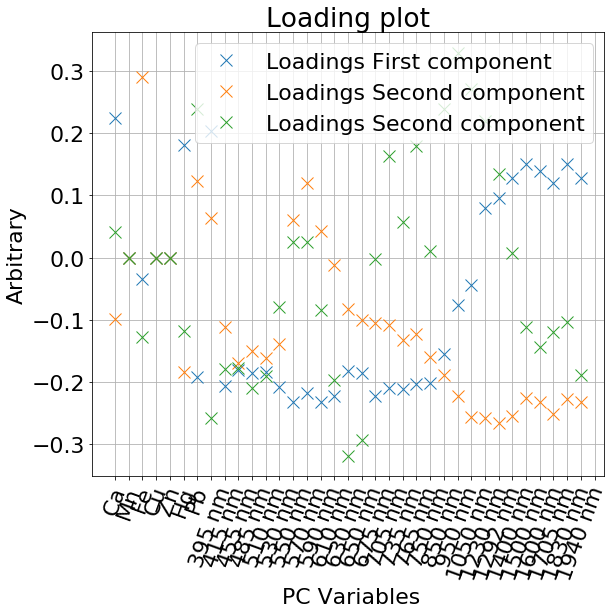

In [107]:
plotPCA3D(xrf_ref,4,0,1,2,labels=ids,variables_name=variables_name,labels_dict=simplelocation,Scaling=True)